In [39]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer , TFBertForSequenceClassification
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score

In [1]:


# Load the final dataset created in the data analysis notebook
df = pd.read_csv('../data_analysis/final_dataset.csv')

# Combine non-alphabetical characters removal and lowercase conversion into one step
df['text'] = df['text'].str.replace(r'[^a-zA-Z0-9\s]', '').str.lower()

# Split 80% for training and 20% for validation and testing combined
train_df, val_test_df = train_test_split(df, test_size=0.2, random_state=42)

# Split the remaining 20% into equal parts for validation and testing (10% each)
val_df = val_test_df.iloc[:int(len(val_test_df) * 0.1)]
test_df = val_test_df.iloc[int(len(val_test_df) * 0.1):int(len(val_test_df) * 0.2)]

# Print the size of each dataset
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Testing set size:", len(test_df))
# Filter out data points from the validation set that are also in the training set based on 'id' and 'text'
val_df = val_df[~val_df.set_index(['id', 'text']).index.isin(train_df.set_index(['id', 'text']).index)]

# Filter out data points from the testing set that are also in the training set based on 'id' and 'text'
test_df= test_df[~test_df.set_index(['id', 'text']).index.isin(train_df.set_index(['id', 'text']).index)]


# Print the size of each dataset
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Testing set size:", len(test_df))

label_counts = train_df['label'].value_counts()
ai_generated_count = label_counts[1]
human_written_count = label_counts[0]
print("AI-generated labels:", ai_generated_count)
print("Human-written labels:", human_written_count)

NameError: name 'pd' is not defined

In [17]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [23]:
# Define a function to expand contractions
def expand_contractions(text):
    # Define contraction mappings
    contractions = {
        "I'm": "I am",
        "you're": "you are",
        "he's": "he is",
        "she's": "she is",
        "it's": "it is",
        "we're": "we are",
        "they're": "they are",
        "can't": "cannot",
        "won't": "will not",
        "didn't": "did not",
        "doesn't": "does not",
        "haven't": "have not",
        "hasn't": "has not",
        "hadn't": "had not",
        "aren't": "are not",
        "weren't": "were not",
        "couldn't": "could not",
        "shouldn't": "should not",
        "wouldn't": "would not",
        "gonna": "going to"
    }
    
    # Replace contractions with their expanded forms
    for contraction, expanded in contractions.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', expanded, text)
    
    return text

In [20]:
# Tokenize text using NLTK tokenizer
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Apply expansion of contractions using regex
train_df['expanded_text'] = train_df['text'].apply(expand_contractions)
val_df['expanded_text'] = val_df['text'].apply(expand_contractions)
test_df['expanded_text'] = test_df['text'].apply(expand_contractions)


In [22]:
# Tokenize and encode the text data using BERT tokenizer for training, validation, and testing
train_encodings = tokenizer(train_df['expanded_text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='tf')
val_encodings = tokenizer(val_df['expanded_text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='tf')
test_encodings = tokenizer(test_df['expanded_text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='tf')


# Convert labels to int if they are not
train_labels = train_df['label'].astype(int).tolist()
val_labels = val_df['label'].astype(int).tolist()
test_labels = test_df['label'].astype(int).tolist()

In [24]:

# Define the BERT classification model
model1 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
   
  

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model1.summary()


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Extract inputs and labels from batch encodings
train_inputs = train_encodings['input_ids']
val_inputs = val_encodings['input_ids']

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [27]:

# Train the BERT model using the training set and validate on the validation set
history = model1.fit(
    train_inputs,
    train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(val_inputs, val_labels),
)

Epoch 1/10
20/20 [==============================] - 336s 16s/step - loss: 0.6088 - accuracy: 0.6703 - val_loss: 0.4364 - val_accuracy: 0.8125
Epoch 2/10
20/20 [==============================] - 315s 16s/step - loss: 0.3722 - accuracy: 0.8656 - val_loss: 0.1695 - val_accuracy: 1.0000
Epoch 3/10
20/20 [==============================] - 298s 15s/step - loss: 0.1742 - accuracy: 0.9500 - val_loss: 0.1928 - val_accuracy: 0.9375
Epoch 4/10
20/20 [==============================] - 317s 16s/step - loss: 0.0925 - accuracy: 0.9766 - val_loss: 0.0834 - val_accuracy: 0.9375
Epoch 5/10
20/20 [==============================] - 301s 15s/step - loss: 0.0513 - accuracy: 0.9859 - val_loss: 0.0788 - val_accuracy: 0.9375
Epoch 6/10
20/20 [==============================] - 304s 15s/step - loss: 0.0257 - accuracy: 0.9937 - val_loss: 0.0532 - val_accuracy: 1.0000
Epoch 7/10
20/20 [==============================] - 312s 16s/step - loss: 0.0120 - accuracy: 0.9984 - val_loss: 0.0353 - val_accuracy: 1.0000
Epoch 

In [28]:
# Save the entire trained model
model1.save_pretrained("../models/bert/")

In [29]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model1.evaluate(val_inputs, val_labels)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')



1/1 [==============================] - 3s 3s/step - loss: 0.0770 - accuracy: 0.9375
Validation Loss: 0.07699780911207199, Validation Accuracy: 0.9375


In [30]:
# Test the model on the testing set
test_inputs = test_encodings['input_ids']
test_labels = np.array(test_labels)
test_loss, test_accuracy = model1.evaluate(test_inputs, test_labels)
print(f'Testing Loss: {test_loss}, Testing Accuracy: {test_accuracy}')


1/1 [==============================] - 4s 4s/step - loss: 0.1221 - accuracy: 0.9375
Testing Loss: 0.12211547791957855, Testing Accuracy: 0.9375


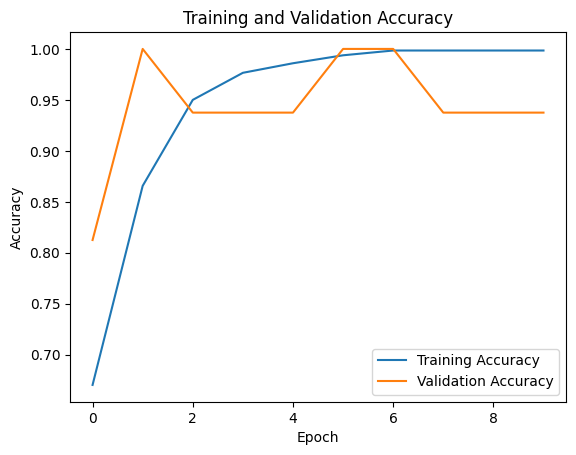

In [34]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

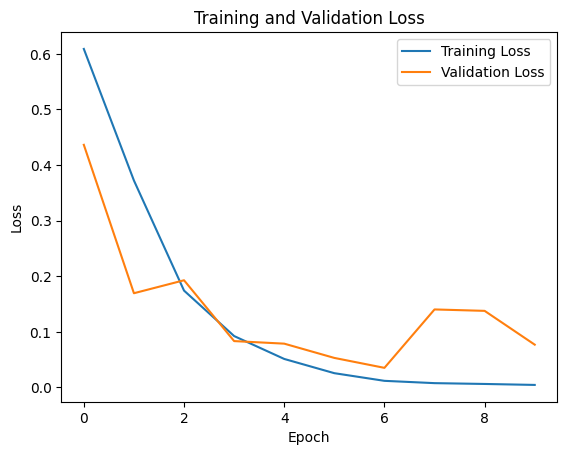

In [36]:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 34s 34s/step


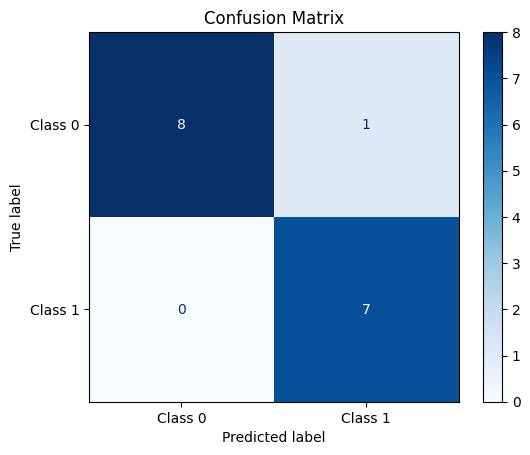

In [38]:


# Predict labels for the test set
predictions = model1.predict(test_inputs)
predicted_labels = np.argmax(predictions.logits, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


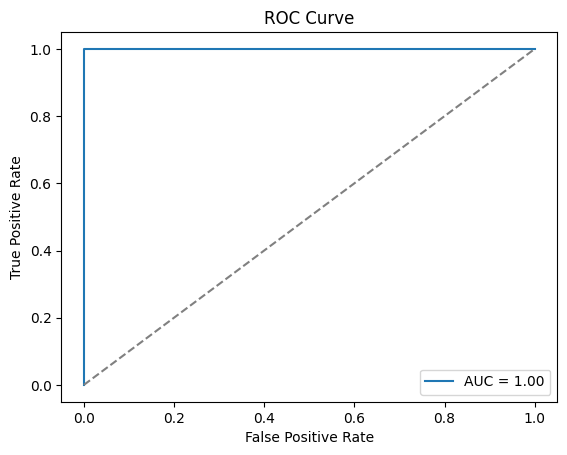

: 

In [40]:
# Get probabilities for positive class
probabilities = tf.nn.softmax(predictions.logits)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(test_labels, probabilities)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()